In [1]:
#!/usr/bin/env python3
"""posmatch2
James Gardner 2019
run in directory with NVSSCatalog.text and TGSSADR1_7sigma_catalog.tsv
creates: matches.npy, catalogue.csv"""

import numpy as np
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# separation limits, 30'' and 20'
GOOD = 30*1/3600
LOOSE = 2*60*1/3600
GOOD = LOOSE

In [2]:
def generate_matches():
    """generates matches.py, containing all pairs from tgss, nvss
    s.t. a basic estimate for their separation is closer than GOOD"""
    tgss = np.genfromtxt(
        fname="TGSSADR1_7sigma_catalog.tsv",
        delimiter='\t',
        skip_header=1,
        usecols=(1,3))
    #Source_name,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...

    with fits.open("CATALOG.FIT") as hdulist:
        data = hdulist[1].data
        nvss = np.column_stack((data['RA(2000)'],data['DEC(2000)']))
    #     hdulist.info()
    #     hdr = hdulist[0].header
    #     print(repr(hdr))
    #     cols = hdulist[1].columns
    #     cols.info()    

    print(np.shape(tgss),np.shape(nvss))
    tgss = tgss[tgss[:,1].argsort()]
    nvss = nvss[nvss[:,1].argsort()]
    # print(tgss)
    # print(nvss)

    # create 0.1 deg bins of nvss
    nvss_dec_min = round(nvss[:,1].min(),1)
    nvss_dec_max = round(nvss[:,1].max(),1)

    # chunkis is index of where bin starts
    bin_size = 0.1
    mark = nvss_dec_min - bin_size
    chunkis = []
    count = 0
    # finding the first element in each bin
    for i,dec in enumerate(nvss[:,1]):    
        if mark < dec < mark + bin_size:
            chunkis.append(i)
            mark += bin_size

    bins = [x/10 for x in range(int((nvss_dec_min-bin_size)*10),
                                int((nvss_dec_max+bin_size+0.01)*10))]

    cos_dec = np.array([np.cos(dec*np.pi/180) for dec in bins])

    print(chunkis[:5],'...',chunkis[-5:])
    print(bins[:5],'...',bins[-5:])

    matches = []
    bar = tqdm(total=len(tgss))

    # this takes at least 30 minutes to complete
    for i1,p1 in enumerate(tgss):
        if p1[1] < nvss_dec_min - 0.1:
            bar.update(1)
            continue
        elif p1[1] > nvss_dec_max + 0.1:
            break

        which_bin = bins.index(np.floor(p1[1]*10)/10)
        # look both ways: -1, 0, +1
        nslice = chunkis[which_bin-1],chunkis[which_bin+2]

        for i2,p2 in enumerate(nvss[nslice[0]:nslice[1]]):
            # else need careful with azimuth near poles
            #if abs((p1[0]-p2[0])*np.cos(p1[1]))<GOOD and abs(p1[1]-p2[1])<GOOD:
            #if abs(p1[1]-p2[1])<GOOD:
            if (abs((p1[0]-p2[0])*cos_dec[which_bin]) < GOOD
                    and abs(p1[1]-p2[1]) < GOOD):
                matches.append((p1,p2))
                #print('matched: ',p1,p2,sep='')
        bar.postfix = 'matches = {}'.format(len(matches))
        bar.update(1)
    matches = np.array(matches)
    np.save('matches.npy', matches)

In [3]:
def geodist(p1,p2):
    """given two points close on the unit sphere,
    return their geodesic distance,
    must be in radians!"""
    ra1,dec1,ra2,dec2 = p1[0],p1[1],p2[0],p2[1]
    #https://en.wikipedia.org/wiki/Great-circle_distance#Formulae
    decdiff = (dec1-dec2)/2
    radiff  = (ra1-ra2)/2
    better_circle = 2*np.arcsin(np.sqrt(np.sin(decdiff)**2
                    + np.cos(dec1)*np.cos(dec2) * np.sin(radiff)**2))
    r = 1
    return better_circle*r

def degdist(p1,p2):
    """calls geodist on argument points,
    after converting from deg to rad and back"""
    return 180/np.pi*geodist([x*np.pi/180 for x in p1],
                             [x*np.pi/180 for x in p2])

In [4]:
matches = np.load('matches.npy')
print('initial matches:',matches.shape)

# filter with geodesic distance metric
catalogue = []
for m in tqdm(matches):
    # tgss,nvss
    p1,p2 = m
    d = degdist(p1,p2)
    if d < GOOD:
        catalogue.append(('',p1[0],p1[1],\
                          '',p2[0],p2[1],\
                          d,0,0,0,0))
# Tname,Tra,Tdec,Nname,Nra,Ndec,sepdist,nonuniqueflag,Tflux,Nflux,alpha
catalogue = np.array(catalogue,dtype=object)
print('catalogue:',catalogue.shape)
print(catalogue[:5])

initial matches: (752874, 2, 2)



catalogue: (720631, 11)
[['' 194.89285 -40.3782 '' 194.89705275844463 -40.37910459184406
  0.0033269169946461537 0 0 0 0]
 ['' 249.00481 -40.37202 '' 249.0051205759682 -40.373689585817495
  0.001686268510645244 0 0 0 0]
 ['' 281.11865 -40.36609 '' 281.12787966512604 -40.369811721711265
  0.007956222815131907 0 0 0 0]
 ['' 281.11865 -40.36609 '' 281.1604078720839 -40.36764327853966
  0.031853758065035126 0 0 0 0]
 ['' 281.11865 -40.36609 '' 281.1131907052817 -40.36367443721616
  0.004810141887820146 0 0 0 0]]


In [5]:
# flag all non-one-to-one
# takes 30 secs to complete
for i,m in enumerate(tqdm(catalogue)):
    p1ra,p1dec,p2ra,p2dec = m[1],m[2],m[4],m[5]
    # again, abusing sorting to only check nearby
    nearby = 10
    if nearby < i < len(catalogue)-nearby:
        rest_wo = np.concatenate((catalogue[i-nearby:i],catalogue[i+1:i+1+nearby]))
    elif i < nearby:
        rest_wo = np.concatenate((catalogue[:i],catalogue[i+1:i+1+nearby]))
    elif len(catalogue)-nearby < i:
        rest_wo = np.concatenate((catalogue[i-nearby:i],catalogue[i+1:]))

    tgss_wo = rest_wo[:,(1,2)]
    nvss_wo = rest_wo[:,(4,5)]
    
    #if ([p1ra,p1dec] in tgss_wo or [p2ra,p2dec] in nvss_wo):
    if (np.any((tgss_wo[:]==[p1ra,p1dec]).all(1)) or
        np.any((nvss_wo[:]==[p2ra,p2dec]).all(1))):
        catalogue[i][7] = 1

# paper says 553301 tgss non-unique sources in 30''
print('catalogue:',catalogue.shape)
print(catalogue[:5])


catalogue: (720631, 11)
[['' 194.89285 -40.3782 '' 194.89705275844463 -40.37910459184406
  0.0033269169946461537 0 0 0 0]
 ['' 249.00481 -40.37202 '' 249.0051205759682 -40.373689585817495
  0.001686268510645244 0 0 0 0]
 ['' 281.11865 -40.36609 '' 281.12787966512604 -40.369811721711265
  0.007956222815131907 1 0 0 0]
 ['' 281.11865 -40.36609 '' 281.1604078720839 -40.36764327853966
  0.031853758065035126 1 0 0 0]
 ['' 281.11865 -40.36609 '' 281.1131907052817 -40.36367443721616
  0.004810141887820146 1 0 0 0]]


In [6]:
# f%%ss means flux attached: ra, dec, peak flux
tgss_labels = np.genfromtxt('TGSSADR1_7sigma_catalog.tsv',
                            delimiter='\t', skip_header=1, usecols=0, dtype=str)
# tgss_labels = np.array([name[8:] for name in tgss_labels.tolist()])
ftgss = np.genfromtxt('TGSSADR1_7sigma_catalog.tsv',
                      delimiter='\t', skip_header=1, usecols=(1,3,7))
tgss_labels = tgss_labels[ftgss[:,1].argsort()]
ftgss = ftgss[ftgss[:,1].argsort()]

In [7]:
with fits.open("CATALOG.FIT") as hdulist:
    data = hdulist[1].data
    # jansky?!/beam
    fnvss = np.column_stack((data['RA(2000)'],data['DEC(2000)'],data['PEAK INT']))
fnvss = fnvss[fnvss[:,1].argsort()]

In [8]:
# divmod returns quotient and remainder
def deci_deg_to_deg_min_sec(deci_deg):
    """https://stackoverflow.com/questions/2579535\
    /convert-dd-decimal-degrees-to-dms-degrees-minutes-seconds-in-python"""
    is_positive = (deci_deg >= 0)
    deci_deg = abs(deci_deg)
    minutes,seconds = divmod(deci_deg*3600,60)
    degrees,minutes = divmod(minutes,60)
    degrees = degrees if is_positive else -degrees
    return (degrees,minutes,seconds)

def deci_deg_to_hr_min_sec(deci_deg):
    """assume deci_deg +ve"""
    deci_hours = deci_deg/15.
    schminutes,schmeconds = divmod(deci_hours*3600,60)
    hours,schminutes = divmod(schminutes,60)   
    #assert hours*15+schminutes*15/60+schmeconds*15/3600 == deci_deg
    return (hours,schminutes,schmeconds)

In [9]:
# generate NVSS names as per https://heasarc.gsfc.nasa.gov/W3Browse/all/nvss.html
def iau_designation(ra,dec):
    hr,schmin,schmec = deci_deg_to_hr_min_sec(ra)
    rhh = str(int(hr)).zfill(2)
    rmm = str(int(schmin)).zfill(2)
    rss = str(int(schmec - schmec%1)).zfill(2)

    deg,minu,sec = deci_deg_to_deg_min_sec(dec)
    sgn = '+' if deg>=0 else '-'
    ddd = str(int(abs(deg))).zfill(2)
    dmm = str(int(minu)).zfill(2)
    dss = str(int(sec - sec%1)).zfill(2)

    designation = ''.join(('NVSS J',rhh,rmm,rss,sgn,ddd,dmm,dss))
    return designation

In [10]:
# takes about 10 seconds to run
# runs off the sorted fnvss and will follow the same indicies
nvss_labels = np.array([iau_designation(p[0],p[1]) for p in tqdm(fnvss)])

In [11]:
# tgss in mJy/beam
tgssbeam = 25#''
ftgss[:,2] = ftgss[:,2]*1e-3#*tgssbeam
# nvss in Jy/beam
nvssbeam = 45#''
fnvss[:,2] = fnvss[:,2]#*nvssbeam

In [12]:
# add labels, flux densities, and spectral index to catalogue
# Tname,Tra,Tdec,Nname,Nra,Ndec,sepdist,nonuniqueflag,Tflux,Nflux,alpha
freq_nvss, freq_tgss = 1.4e9,150e6

# takes less than 10 seconds to run
for i,m in enumerate(tqdm(catalogue)):
    tdec,ndec = m[2],m[5]
    # searchsorted gives index value if equal to or next if not
    ti = np.searchsorted(ftgss[:,1],tdec)
    ni = np.searchsorted(fnvss[:,1],ndec)
    t_name,n_name = tgss_labels[ti],nvss_labels[ni]
    s_tgss,s_nvss = ftgss[ti][2],fnvss[ni][2]
    alpha = np.log(s_tgss/s_nvss)/np.log(freq_nvss/freq_tgss)
    
    catalogue[i][0] = t_name
    catalogue[i][3] = n_name
    catalogue[i][8] = s_tgss
    catalogue[i][9] = s_nvss
    catalogue[i][10] = alpha

catalogue_fmt = ('%s','%1.5f','%1.5f','%s','%1.14f','%1.14f',
                 '%1.18f','%i','%1.5f','%1.5f','%1.5f')
np.savetxt('catalogue.csv', catalogue, delimiter=',',fmt = catalogue_fmt)

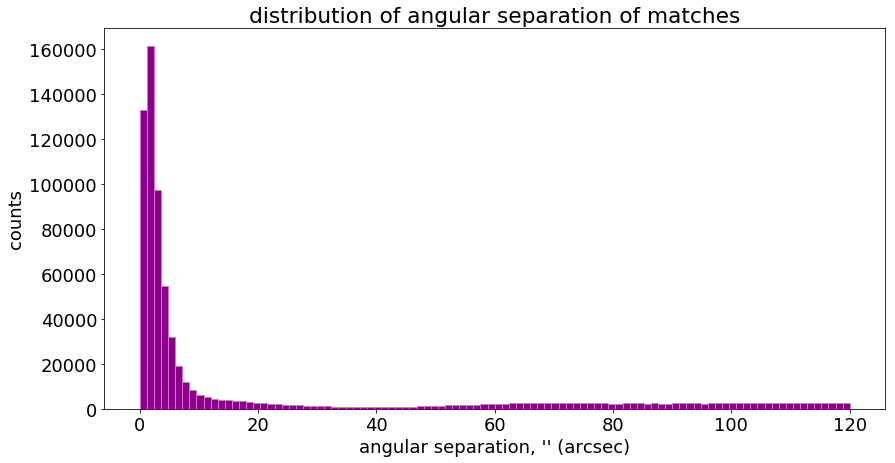

In [13]:
# create histogram of angular separation of matches
# create list of angular separations
seps = [3600*val for val in catalogue[:,6]]

plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 18})
plt.hist(seps, bins=100,color = "darkmagenta", ec="orchid")
plt.xlabel("angular separation, '' (arcsec)")
plt.ylabel('counts')
plt.title('distribution of angular separation of matches')
# plt.show()
plt.savefig('hist_angle.png',bbox_inches='tight')
# plt.clf()

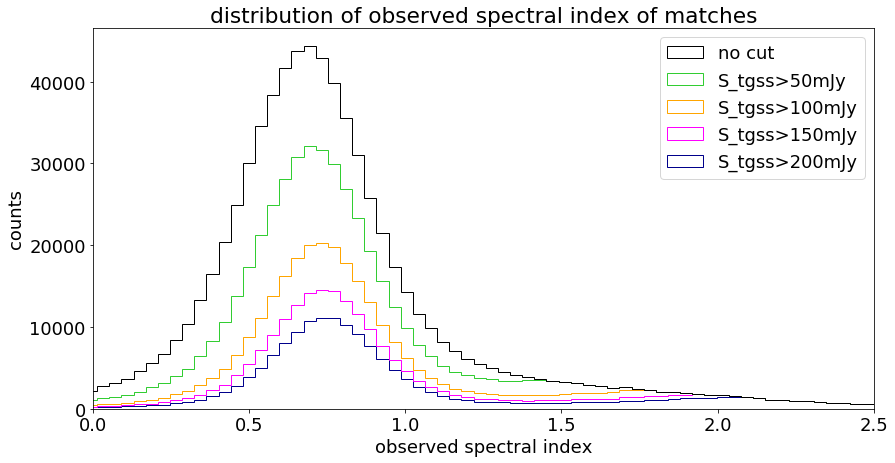

In [14]:
plt.rcParams.update({'font.size': 18})
alpha = catalogue[:,10]
s_tgss = catalogue[:,8]*1e3
allalpha = alpha,alpha[s_tgss>50],alpha[s_tgss>100],alpha[s_tgss>150],alpha[s_tgss>200]

fig,axis = plt.subplots(figsize=(14,7))
plt.hist(allalpha, bins=200, histtype='step', stacked=False, fill=False,\
         label=['no cut','S_tgss>50mJy','S_tgss>100mJy','S_tgss>150mJy','S_tgss>200mJy'],\
         color=['black','limegreen','orange','magenta','darkblue'])
plt.legend(loc='upper right')
handles, labels = axis.get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))
plt.xlim(0,2.5)
plt.xlabel("observed spectral index")
plt.ylabel('counts')
plt.title('distribution of observed spectral index of matches')
# plt.show()
plt.savefig('hist_alpha.png',bbox_inches='tight')
# plt.clf()